<a href="https://colab.research.google.com/github/huygenssteiner/Neural-network-based-denoiser-for-the-stimulated-Raman-scattering-SRS-/blob/main/Ramandenoiserproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<Figure size 1080x360 with 0 Axes>

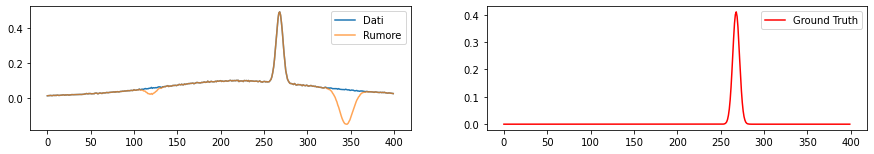

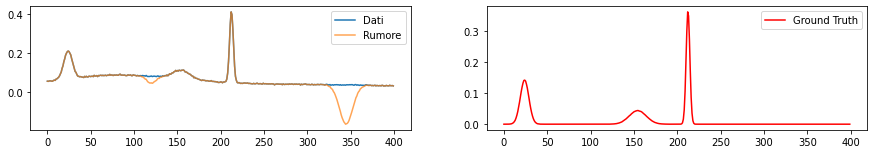

In [ ]:
#####Useful sources for the structures of the machine:
#####https://github.com/shibuiwilliam/DeepLearningDenoise
#####https://arxiv.org/pdf/1608.03981v1.pdf

import numpy as np
import matplotlib.pyplot as plt

file1 = np.load('/content/drive/MyDrive/raman_sim_data.npz')  #Mounting dataset by the drive
X_train = file1['X_train.npy']
X_test = file1['X_test.npy']
Y_train = file1['Y_train.npy']
Y_test = file1['Y_test.npy']
X_train.shape


X_train2=np.reshape(X_train, (8000,400))    #Tensor->array
Y_train2=np.reshape(Y_train, (8000,400))
X_test2=np.reshape(X_test, (2000,400))
Y_test2=np.reshape(Y_test, (2000,400))

plt.figure(figsize=(15,5))
for i in range(1,5,2):
  plt.figure(figsize=(15,5))
  n=np.random.randint(0,2000)
  plt.subplot(2,2,i)
  plt.plot(range(0,400),X_train2[n,:], label='Dati')
  plt.plot(range(0,400),X_train2[n,:]-Y_train2[1,:], alpha=0.7, label='Rumore')
  plt.legend(loc='best')
  plt.subplot(2,2,i+1)
  plt.plot(range(0,400),Y_train2[n,:], label="Ground Truth", color='r')
  plt.legend(loc='best')
  plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 1)]          0         
                                                                 
 Convoluzione_iniziale (Conv  (None, 400, 64)          256       
 1D)                                                             
                                                                 
 re_lu (ReLU)                (None, 400, 64)           0         
                                                                 
 Denoiser1 (Conv1D)          (None, 400, 64)           12352     
                                                                 
 re_lu_1 (ReLU)              (None, 400, 64)           0         
                                                                 
 batch_normalization (BatchN  (None, 400, 64)          256       
 ormalization)                                               

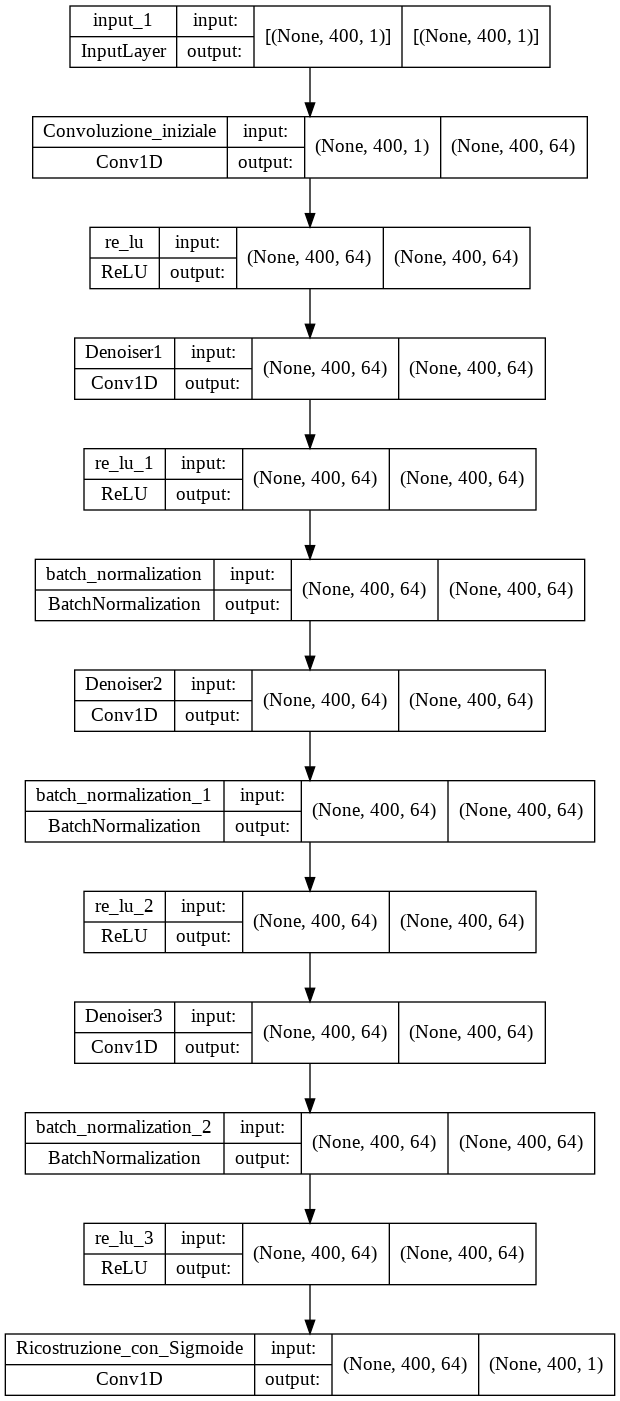

In [ ]:
#@title Model1 (Sigmoid)
import tensorflow as tf
from tensorflow import keras
from keras import layers


inputs= keras.Input(shape=(400,1))

##PRIMO BLOCCO##
x=keras.layers.Conv1D(64, 3,padding='same', name='Convoluzione_iniziale')(inputs)
x=keras.layers.ReLU()(x)
##BLOCCO DENOISING##
x=keras.layers.Conv1D(64, 3,padding='same', name= 'Denoiser1')(x)
x=keras.layers.ReLU()(x)
x=keras.layers.BatchNormalization()(x)  #È il cuore di un denoiser efficace https://arxiv.org/pdf/1608.03981v1.pdf pag.5
##BLOCCO DENOISING##
x=keras.layers.Conv1D(64, 3,padding='same', name= 'Denoiser2')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.ReLU()(x)
##BLOCCO DENOISING##
x=keras.layers.Conv1D(64, 3,padding='same', name= 'Denoiser3')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.ReLU()(x)
##RICOSTRUZIONE##
outputs=keras.layers.Conv1D(1, 3, activation='sigmoid',strides=1,padding='same', name= 'Ricostruzione_con_Sigmoide')(x)

model1 = keras.Model(inputs=inputs,outputs=outputs)
model1.summary()
keras.utils.plot_model(model1, show_shapes=True)

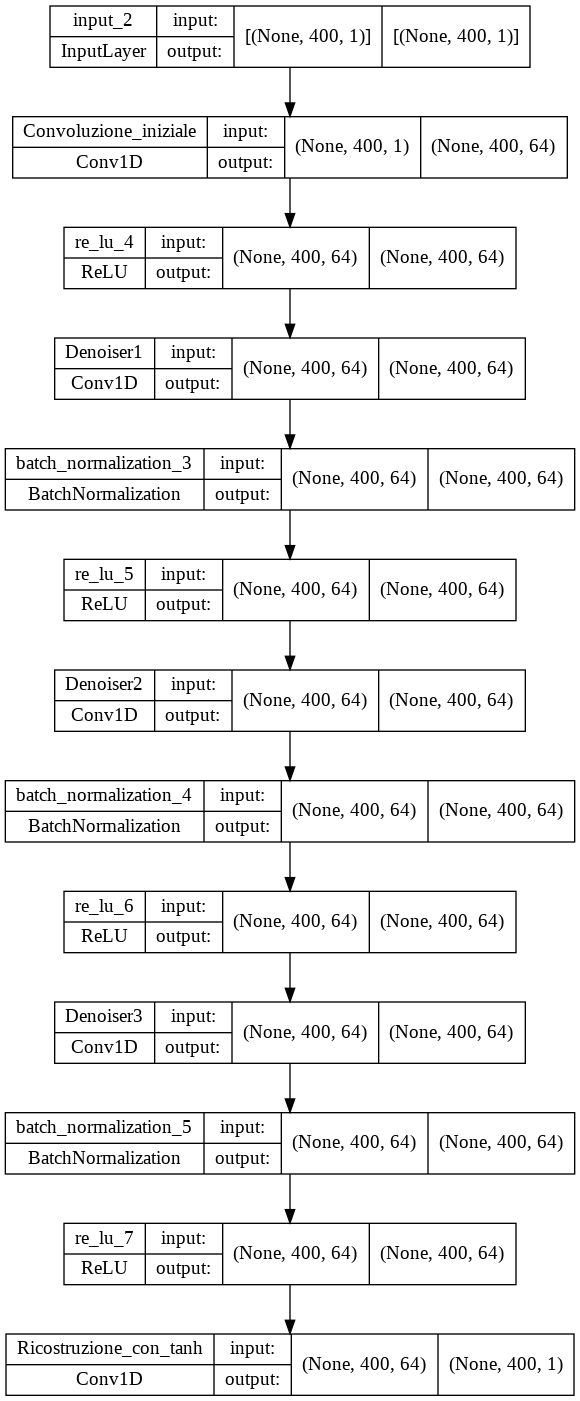

In [ ]:
#@title Model2 (tanh)
inputs= keras.Input(shape=(400,1))

##PRIMO BLOCCO##
x=keras.layers.Conv1D(64, 3,padding='same', name='Convoluzione_iniziale')(inputs)
x=keras.layers.ReLU()(x)
##BLOCCO DENOISING##
x=keras.layers.Conv1D(64, 3,padding='same',name= 'Denoiser1')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.ReLU()(x)
##BLOCCO DENOISING##
x=keras.layers.Conv1D(64, 3,padding='same', name= 'Denoiser2')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.ReLU()(x)
#BLOCCO DENOISING#
x=keras.layers.Conv1D(64, 3,padding='same', name= 'Denoiser3')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.ReLU()(x)
##RICOSTRUZIONE##
outputs=keras.layers.Conv1D(1, 3, activation='tanh',strides=1,padding='same', name= 'Ricostruzione_con_tanh')(x)

model2 = keras.Model(inputs=inputs,outputs=outputs)
#model2.summary()
keras.utils.plot_model(model2, show_shapes=True)

OPTIMIZER ADAM

In [ ]:
LR_ST=1e-3
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

model1.compile(optimizer=OPTIMIZER,
              loss='mse')
model2.compile(optimizer=OPTIMIZER,
              loss='mse')
#Mettiamo una callback per salavare i migliori pesi per la rete, basandoci sulla funzione di loss del validation set
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='denoiser_best',
        monitor='val_loss',
        save_weights_only=True, 
        save_best_only=True,
        save_freq='epoch')

model_checkpoint2 = keras.callbacks.ModelCheckpoint(
        filepath='denoiser_best2',
        monitor='val_loss',
        save_weights_only=True, 
        save_best_only=True,
        save_freq='epoch')

callbacks = [model_checkpoint]
callbacks2 = [model_checkpoint2]

#Stando a quanto letto su https://arxiv.org/pdf/1608.03981v1.pdf pag.5, machine works better for residual learning
history1=model1.fit(X_train2,X_train2-Y_train2, epochs=80, batch_size=128, validation_split=0.3,callbacks=callbacks)
history2=model2.fit(X_train2,X_train2-Y_train2, epochs=80, batch_size=128, validation_split=0.3,callbacks=callbacks2)

Epoch 1/80
44/44 [==============================] - 14s 56ms/step - loss: 0.0160 - val_loss: 0.0840
Epoch 2/80
44/44 [==============================] - 2s 46ms/step - loss: 1.6740e-04 - val_loss: 0.0230
Epoch 3/80
44/44 [==============================] - 2s 48ms/step - loss: 1.1751e-04 - val_loss: 0.0061
Epoch 4/80
44/44 [==============================] - 2s 48ms/step - loss: 9.4790e-05 - val_loss: 0.0019
Epoch 5/80
44/44 [==============================] - 2s 47ms/step - loss: 8.2984e-05 - val_loss: 9.1070e-04
Epoch 6/80
44/44 [==============================] - 2s 48ms/step - loss: 7.4534e-05 - val_loss: 7.9986e-04
Epoch 7/80
44/44 [==============================] - 2s 47ms/step - loss: 7.5445e-05 - val_loss: 9.0829e-04
Epoch 8/80
44/44 [==============================] - 2s 47ms/step - loss: 6.8112e-05 - val_loss: 0.0011
Epoch 9/80
44/44 [==============================] - 2s 45ms/step - loss: 6.7050e-05 - val_loss: 0.0015
Epoch 10/80
44/44 [==============================] - 2s 46ms/ste

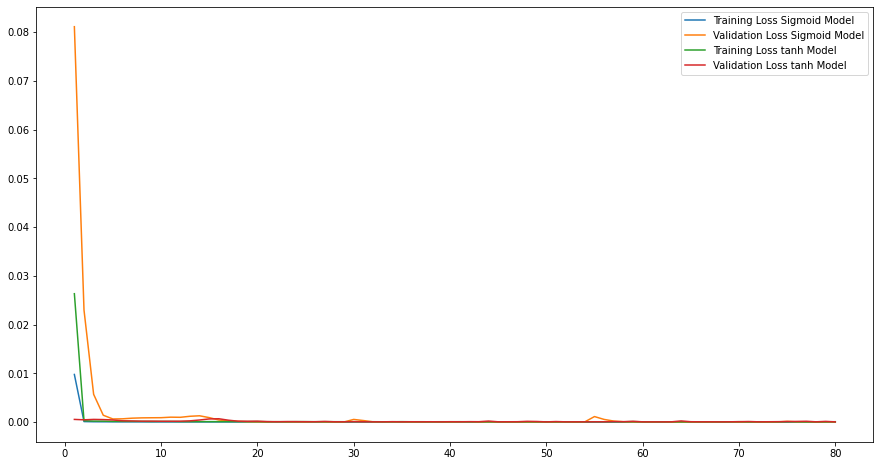

In [ ]:
#Plot loss vs epochs for the training and validation set for models with activation function Sigmoid and tanh
loss=history1.history['loss']
val_loss=history1.history['val_loss']

loss2=history2.history['loss']
val_loss2=history2.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(15,8))
plt.plot(epochs_range, loss, label='Training Loss Sigmoid Model')
plt.plot(epochs_range, val_loss, label='Validation Loss Sigmoid Model')
plt.legend(loc='upper right')

plt.plot(epochs_range, loss2, label='Training Loss tanh Model')
plt.plot(epochs_range, val_loss2, label='Validation Loss tanh Model')
plt.legend(loc='upper right')

Training Set
250/250 - 1s - loss: 0.0027
250/250 - 1s - loss: 0.0027

Train Loss for Sigmoid: 0.0027348771691322327

Train Loss for tahn: 0.0027320459485054016


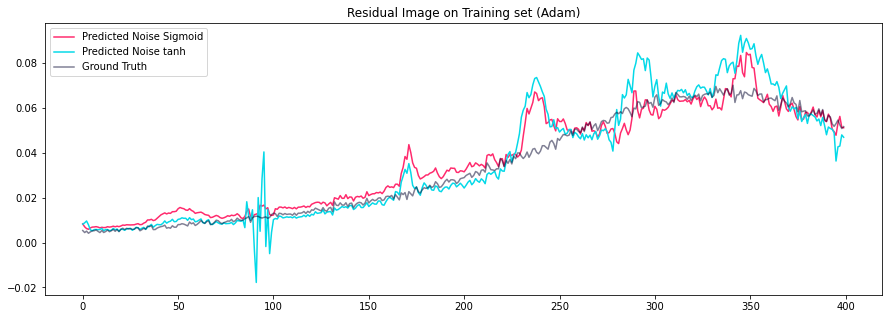

Test set
63/63 - 0s - loss: 0.0027
63/63 - 0s - loss: 0.0028

Test loss for Sigmoid: 0.0027335635386407375
63/63 - 0s - loss: 0.0028

Test loss for tanh: 0.0027663076762109995


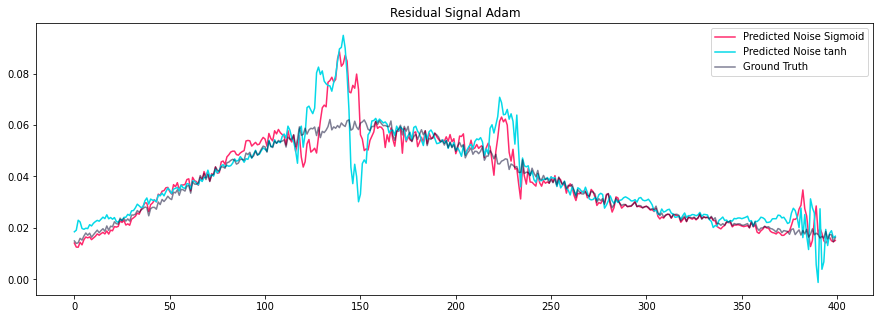

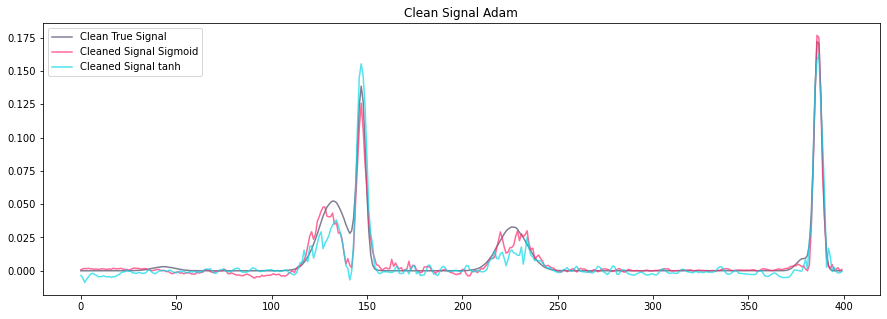

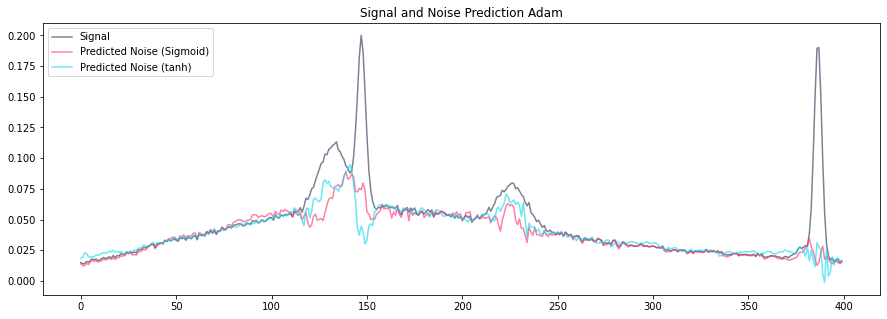

In [ ]:
print('Training Set')

train_loss= model1.evaluate(X_train2, Y_train2, verbose=2)
train_loss2= model2.evaluate(X_train2, Y_train2, verbose=2)
print('\nTrain Loss for Sigmoid:', train_loss)
print('\nTrain Loss for tahn:', train_loss2)

pred_noise=model1.predict(X_train2)
pred_noise2=model2.predict(X_train2)

n=np.random.randint(0,2000)
plt.figure(figsize=(15,5))
plt.plot(range(0,400),pred_noise[n,:], label='Predicted Noise Sigmoid', color="#ff2a6d")
plt.plot(range(0,400),pred_noise2[n,:], label='Predicted Noise tanh', color="#05d9e8")
plt.plot(range(0,400),X_train2[n,:]-Y_train2[n,:], label='Ground Truth', color="#01012b", alpha=0.5)
plt.legend(loc='best')
plt.title('Residual Image on Training set (Adam)')
plt.show()

print('Test set')

model1.load_weights('denoiser_best')
test_loss= model1.evaluate(X_test2, Y_test2, verbose=2)
model2.load_weights('denoiser_best2')
test_loss2= model2.evaluate(X_test2, Y_test2, verbose=2)
print('\nTest loss for Sigmoid:', test_loss)
test_loss2= model2.evaluate(X_test2, Y_test2, verbose=2)
print('\nTest loss for tanh:', test_loss2)


pred_noise=model1.predict(X_test2)
pred_noise2=model2.predict(X_test2)

plt.figure(figsize=(15,5))
plt.plot(range(0,400),pred_noise[n,:], label='Predicted Noise Sigmoid', color="#ff2a6d")
plt.plot(range(0,400),pred_noise2[n,:], label='Predicted Noise tanh', color="#05d9e8")
plt.plot(range(0,400),X_test2[n,:]-Y_test2[n,:], label='Ground Truth', color="#01012b", alpha=0.5)
plt.title('Residual Signal Adam')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(range(0,400), Y_test[n,:], label="Clean True Signal", color="#01012b", alpha=0.5)
plt.plot(range(0,400), X_test[n,:]-pred_noise[n,:], alpha=0.7, label="Cleaned Signal Sigmoid", color="#ff2a6d")
plt.plot(range(0,400), X_test[n,:]-pred_noise2[n,:], alpha=0.7, label="Cleaned Signal tanh", color="#05d9e8")
plt.title('Clean Signal Adam')
plt.legend(loc="best")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(range(0,400), X_test[n,:], label="Signal", color="#01012b", alpha=0.5)
plt.plot(range(0,400), pred_noise[n,:], alpha=0.6, label="Predicted Noise (Sigmoid)", color="#ff2a6d")
plt.plot(range(0,400), pred_noise2[n,:], alpha=0.6, label="Predicted Noise (tanh)", color="#05d9e8")
plt.title('Signal and Noise Prediction Adam')
plt.legend(loc="best")
plt.show()

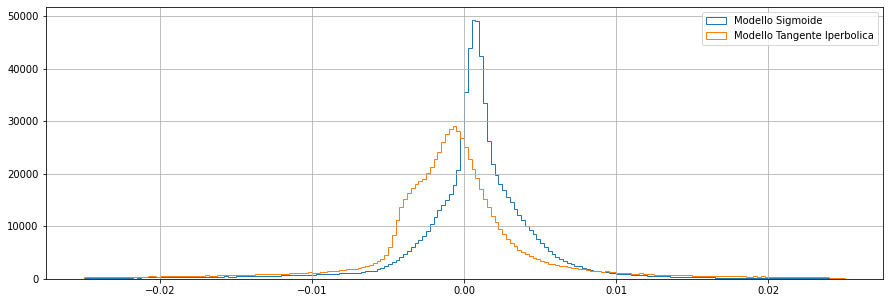

La media degli scarti nel primo modello è: 0.00040262892331746137 e la deviazione standard è: 0.005921090125321436
La media degli scarti nel secondo modello è: -0.001312933783858207 e la deviazione standard è: 0.008480808950097217


In [ ]:
#Statistical study of the error
noise_test=X_test2-Y_test2
err = noise_test-pred_noise.reshape(2000,400)
err2 = noise_test-pred_noise2.reshape(2000,400)

err = err.reshape(800000,1)
err2 = err2.reshape(800000,1)

plt.figure(figsize=(15,5))
plt.hist(err, 200, range=[-0.025,0.025], label="Modello Sigmoide", histtype="step")
plt.grid()
plt.hist(err2, 200, range=[-0.025,0.025], label="Modello Tangente Iperbolica", histtype="step")
plt.legend(loc="best")
plt.show()

mean_err = np.mean(err)
mean_err2 = np.mean(err2)
std_err = np.std(err)
std_err2 = np.std(err2)

print("La media degli scarti nel primo modello è:", mean_err, "e la deviazione standard è:", std_err)
print("La media degli scarti nel secondo modello è:", mean_err2, "e la deviazione standard è:", std_err2)

OTTIMIZZATORE SGD

In [ ]:
LR_ST=1e-3
OPTIMIZER2 = tf.keras.optimizers.SGD(learning_rate=LR_ST)

model1.compile(optimizer=OPTIMIZER2,
              loss='mse')
model2.compile(optimizer=OPTIMIZER2,
              loss='mse')

model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='denoiser_best',
        monitor='val_loss',
        save_weights_only=True, 
        save_best_only=True,
        save_freq='epoch')

model_checkpoint2 = keras.callbacks.ModelCheckpoint(
        filepath='denoiser_best2',
        monitor='val_loss',
        save_weights_only=True, 
        save_best_only=True,
        save_freq='epoch')

callbacks = [model_checkpoint]
callbacks2 = [model_checkpoint2]

history11=model1.fit(X_train2,X_train2-Y_train2, epochs=80, batch_size=128, validation_split=0.3,callbacks=callbacks)
history22=model2.fit(X_train2,X_train2-Y_train2, epochs=80, batch_size=128, validation_split=0.3,callbacks=callbacks2)

Epoch 1/80
44/44 [==============================] - 3s 48ms/step - loss: 3.4309e-05 - val_loss: 3.2332e-05
Epoch 2/80
44/44 [==============================] - 2s 43ms/step - loss: 3.3839e-05 - val_loss: 3.1633e-05
Epoch 3/80
44/44 [==============================] - 2s 43ms/step - loss: 3.3926e-05 - val_loss: 3.1332e-05
Epoch 4/80
44/44 [==============================] - 2s 43ms/step - loss: 3.3238e-05 - val_loss: 3.1178e-05
Epoch 5/80
44/44 [==============================] - 2s 43ms/step - loss: 3.3505e-05 - val_loss: 3.1055e-05
Epoch 6/80
44/44 [==============================] - 2s 45ms/step - loss: 3.2770e-05 - val_loss: 3.0954e-05
Epoch 7/80
44/44 [==============================] - 2s 43ms/step - loss: 3.2652e-05 - val_loss: 3.0862e-05
Epoch 8/80
44/44 [==============================] - 2s 43ms/step - loss: 3.2878e-05 - val_loss: 3.0778e-05
Epoch 9/80
44/44 [==============================] - 2s 43ms/step - loss: 3.2622e-05 - val_loss: 3.0696e-05
Epoch 10/80
44/44 [==================

[3.4308803151361644e-05, 3.3838776289485395e-05, 3.3925552997970954e-05, 3.323842247482389e-05, 3.3504798921057954e-05, 3.277020005043596e-05, 3.265175473643467e-05, 3.287805520812981e-05, 3.2622450817143545e-05, 3.2663254387443885e-05, 3.24064094456844e-05, 3.2450876460643485e-05, 3.2327112421626225e-05, 3.218157871742733e-05, 3.220840881112963e-05, 3.234337054891512e-05, 3.1989518902264535e-05, 3.179203122272156e-05, 3.199099955963902e-05, 3.185143941664137e-05, 3.21224179060664e-05, 3.2144267606781796e-05, 3.191853829775937e-05, 3.231147275073454e-05, 3.20928666042164e-05, 3.211395596736111e-05, 3.218595884391107e-05, 3.2049349101725966e-05, 3.177907638018951e-05, 3.1894887797534466e-05, 3.227234265068546e-05, 3.186509638908319e-05, 3.1896415748633444e-05, 3.183515582350083e-05, 3.175740857841447e-05, 3.1944837246555835e-05, 3.162347275065258e-05, 3.184308297932148e-05, 3.1736723030917346e-05, 3.1611860322300345e-05, 3.216396362404339e-05, 3.194457895006053e-05, 3.2165509765036404e-

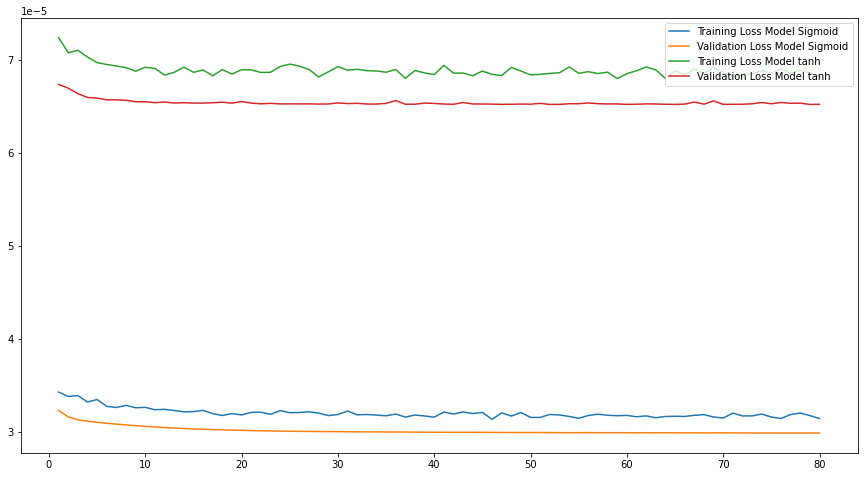

In [ ]:
loss11=history11.history['loss']
val_loss11=history11.history['val_loss']

loss22=history22.history['loss']
val_loss22=history22.history['val_loss']

epochs_range = range(1, len(loss) + 1)
print(loss11)
plt.figure(figsize=(15,8))
plt.plot(epochs_range, loss11, label='Training Loss Model Sigmoid')
plt.plot(epochs_range, val_loss11, label='Validation Loss Model Sigmoid')
plt.legend(loc='upper right')

plt.plot(epochs_range, loss22, label='Training Loss Model tanh')
plt.plot(epochs_range, val_loss22, label='Validation Loss Model tanh')
plt.legend(loc='upper right')

Training Set
250/250 - 1s - loss: 0.0028
250/250 - 1s - loss: 0.0027

Train Loss for Sigmoid: 0.002781340153887868

Train Loss for tahn: 0.0026730212848633528


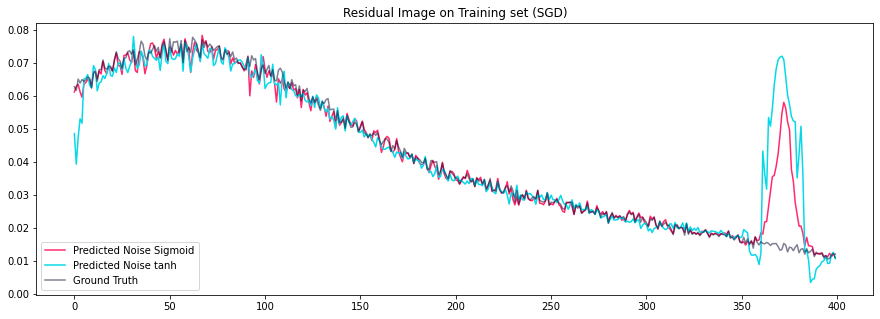

Test set
63/63 - 0s - loss: 0.0028
63/63 - 0s - loss: 0.0027

Test loss for Sigmoid: 0.002813478000462055
63/63 - 0s - loss: 0.0027

Test loss for tanh: 0.0026958032976835966


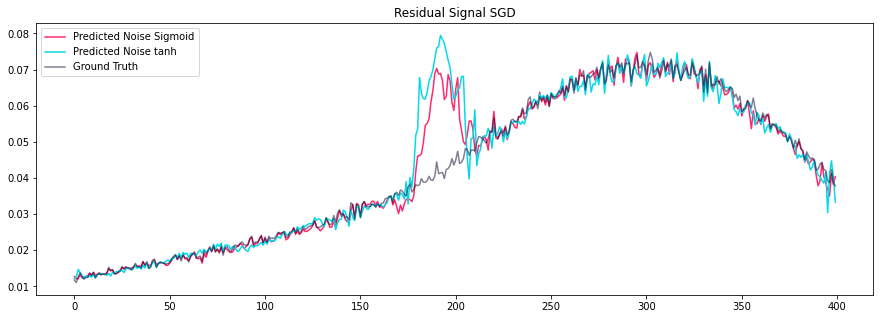

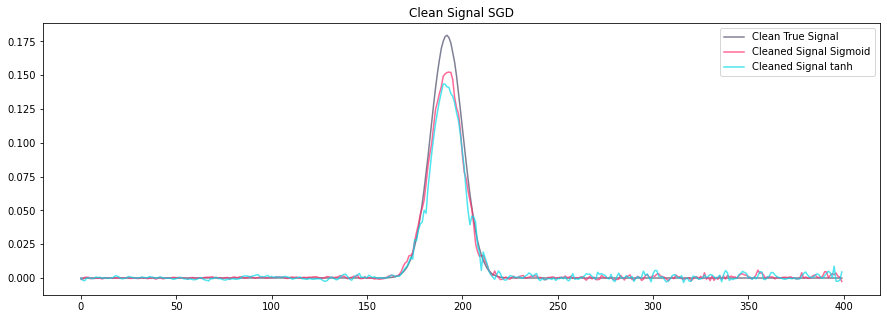

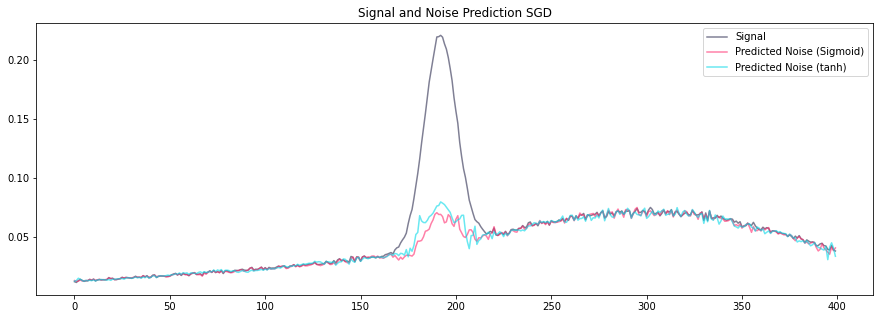

In [ ]:
print('Training Set')
model1.load_weights('denoiser_best')
model2.load_weights('denoiser_best2')
train_loss= model1.evaluate(X_train2, Y_train2, verbose=2)
train_loss2= model2.evaluate(X_train2, Y_train2, verbose=2)
print('\nTrain Loss for Sigmoid:', train_loss)
print('\nTrain Loss for tahn:', train_loss2)

pred_noise=model1.predict(X_train2)
pred_noise2=model2.predict(X_train2)

n=np.random.randint(0,2000)
plt.figure(figsize=(15,5))
plt.plot(range(0,400),pred_noise[n,:], label='Predicted Noise Sigmoid', color="#ff2a6d")
plt.plot(range(0,400),pred_noise2[n,:], label='Predicted Noise tanh', color="#05d9e8")
plt.plot(range(0,400),X_train2[n,:]-Y_train2[n,:], label='Ground Truth', color="#01012b", alpha=0.5)
plt.title('Residual Image on Training set (SGD)')
plt.legend(loc='best')
plt.show()

print('Test set')


test_loss= model1.evaluate(X_test2, Y_test2, verbose=2)
test_loss2= model2.evaluate(X_test2, Y_test2, verbose=2)
print('\nTest loss for Sigmoid:', test_loss)

pred_noise=model1.predict(X_test2)
pred_noise2=model2.predict(X_test2)
test_loss2= model2.evaluate(X_test2, Y_test2, verbose=2)
print('\nTest loss for tanh:', test_loss2)

plt.figure(figsize=(15,5))
plt.plot(range(0,400),pred_noise[n,:], label='Predicted Noise Sigmoid', color="#ff2a6d")
plt.plot(range(0,400),pred_noise2[n,:], label='Predicted Noise tanh', color="#05d9e8")
plt.plot(range(0,400),X_test2[n,:]-Y_test2[n,:], label='Ground Truth', color="#01012b", alpha=0.5)
plt.title('Residual Signal SGD')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(range(0,400), Y_test[n,:], label="Clean True Signal", color="#01012b", alpha=0.5)
plt.plot(range(0,400), X_test[n,:]-pred_noise[n,:], alpha=0.7, label="Cleaned Signal Sigmoid", color="#ff2a6d")
plt.plot(range(0,400), X_test[n,:]-pred_noise2[n,:], alpha=0.7, label="Cleaned Signal tanh", color="#05d9e8")
plt.title('Clean Signal SGD')
plt.legend(loc="best")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(range(0,400), X_test[n,:], label="Signal", color="#01012b", alpha=0.5)
plt.plot(range(0,400), pred_noise[n,:], alpha=0.6, label="Predicted Noise (Sigmoid)", color="#ff2a6d")
plt.plot(range(0,400), pred_noise2[n,:], alpha=0.6, label="Predicted Noise (tanh)", color="#05d9e8")
plt.title('Signal and Noise Prediction SGD')
plt.legend(loc="best")
plt.show()

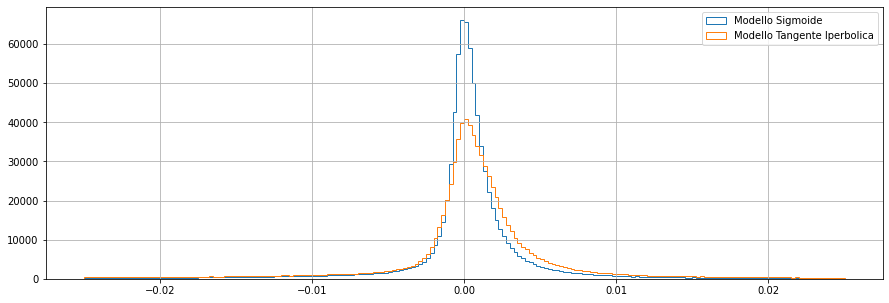

La media degli scarti nel primo modello è: -1.7907652496141665e-05 e la deviazione standard è: 0.0055697099868370886
La media degli scarti nel secondo modello è: 2.7806004940248678e-05 e la deviazione standard è: 0.008300989781503832


In [ ]:
noise_test=X_test2-Y_test2
err = noise_test-pred_noise.reshape(2000,400)
err2 = noise_test-pred_noise2.reshape(2000,400)

err = err.reshape(800000,1)
err2 = err2.reshape(800000,1)

plt.figure(figsize=(15,5))
plt.hist(err, 200, range=[-0.025,0.025], label="Modello Sigmoide", histtype="step")
plt.grid()
plt.hist(err2, 200, range=[-0.025,0.025], label="Modello Tangente Iperbolica", histtype="step")
plt.legend(loc="best")
plt.show()

mean_err = np.mean(err)
mean_err2 = np.mean(err2)
std_err = np.std(err)
std_err2 = np.std(err2)

print("La media degli scarti nel primo modello è:", mean_err, "e la deviazione standard è:", std_err)
print("La media degli scarti nel secondo modello è:", mean_err2, "e la deviazione standard è:", std_err2)